<a href="https://colab.research.google.com/github/denizmsayin/singan/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess as sp
from time import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.__version__

'1.5.0+cu101'

## Notes
- Every generator and critic at every scale has the same architecture, with 5 Conv(3x3)-BN-LReLU layers.
- The patch size is given as 11x11, which comes from the receptive field of the 5 layer deep network.
- How the number of kernels change is not exactly clear, paper says "start with 32, double once every 4 scales"
- It is not clear whether the conv layers use padding (zero, reflect?) to preserve size or not. We assume for now that the generators do preserve the size, but it does not seem necessary for the critics.
- How the downsampling is done is not clear from the paper. We assume bicubic interpolation.
- For the coarsest scale, authors say that "the effective receptive field at this level is typically∼1/2of the image’s height". ~~We assume that this means the input size at the coarsest scale is somewhere between 20 and 25 pixels.~~ The authors later state that they use 25 px for the coarsest and 250 pixels for the finest scale along with a rescaling ratio of 4/3. 
- Lots of training details are given in the supplementary material.
- It is not clear 

In [0]:
def prepare_bsds300():
  if os.path.isdir('BSDS300'):
    print('Dataset already downloaded')
  else:
    sp.call(('wget', 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'))
    sp.call(('tar', '-xvzf', 'BSDS300-images.tgz'))
    sp.call(('rm', '-f', 'BSDS300-images.tgz'))
    print('Downloaded dataset successfully')

In [0]:
class Conv2DBlock(nn.Module):
  """ Combine Conv2d-BN-LReLU into a single block """
  # the 0.2 negative slope is given in the supplementary materials
  def __init__(self, in_channels, out_channels, kernel_size, activation, conv_kwargs={}, bn_kwargs={}):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **conv_kwargs)
    self.bn = nn.BatchNorm2d(out_channels, **bn_kwargs)
    self.activ = activation

  def forward(self, x):
    return self.activ(self.bn(self.conv(x)))

class SGNet(nn.Module):
  def __init__(self, output_channels=3, kernel_count=32, final_activation=nn.Tanh(), final_bn=False, num_blocks=5):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layers.append(nn.ZeroPad2d(num_blocks)) # initial padding, as explained in the SM
    in_channels = 3
    for _ in range(num_blocks-1): # multiple Conv2D blocks with LeakyReLU
      self.layers.append(Conv2DBlock(in_channels, kernel_count, 3, nn.LeakyReLU(negative_slope=0.2)))
      in_channels = kernel_count
    # the final activation depends on whether this is the generator or critic
    if final_bn:
      self.layers.append(Conv2DBlock(kernel_count, output_channels, 3, final_activation))
    else:
      self.layers.append(nn.Conv2d(kernel_count, output_channels, 3))
      self.layers.append(final_activation)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

class Mean(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return torch.mean(x)

# [gen1] -> View, crit1 = View + crit1
# [gen1, gen2] -> View, crit2 = View + crit2
# ...

def sample_noise_like(ref_img, device='cpu'):
  return torch.from_numpy(np.random.uniform(-1, 1, size=ref_img.shape).astype(ref_img.dtype)).to(device)

class MultiScaleSGNetView(nn.Module):
  def __init__(self, scales, scaling_factor, noise_sampler):
    # scales = [gen1, gen2 ...]
    self.scales = scales
    self.noise_sampler = noise_sampler
    self.scaling_factor = scaling_factor # e.g. 4/3
    for g in self.scales[:-1]:
      g.requires_grad_(False)

  def forward(self, x, z_input=None):
    """
    z_input: either None (noise is generated automatically), 
             a single tensor (used as input to the coarsest scale)
             or a list of tensors (used as input to each scale in asc. order)
    """
    for i, g in enumerate(self.scales):
      if z_input is None:
        z = self.noise_sampler(x)
      elif type(z_input) is list:
        z = z_input[i]
      else:
        z, z_input = z_input, None
      x_gen = g(x, z)
      x = F.interpolate(x_gen, scaling_factor=self.scaling_factor, mode='nearest')
  

Dataset already downloaded


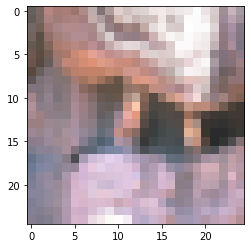

In [3]:
prepare_bsds300()

DS_DIR = 'BSDS300/images/train'
EXAMPLE_IDX = 11
IMG_LIST = sorted(os.listdir(DS_DIR))
EXAMPLE_IMG_PATH = os.path.join(DS_DIR, IMG_LIST[EXAMPLE_IDX])

orig_img_uint = np.array(Image.open(EXAMPLE_IMG_PATH).resize((25, 25), Image.BICUBIC))
plt.imshow(orig_img_uint)

In [0]:
# as given in the paper (LR decrease not implemented)
LEARNING_RATE = 0.0005
BETA_1 = 0.5
BETA_2 = 0.999
NUM_ITERS = 2000
LR_DROP_STEP = 1600
LR_DROP_MULT = 0.1
GEN_STEP_PER_ITER = 3
DIS_STEP_PER_ITER = 3
REC_ALPHA = 10.0
GP_WEIGHT = 0.1

PRINT_EVERY = 50
DEVICE = 'cuda'

SGNet(
  (layers): ModuleList(
    (0): ZeroPad2d(padding=(5, 5, 5, 5), value=0.0)
    (1): Conv2DBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2)
    )
    (2): Conv2DBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2)
    )
    (3): Conv2DBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2)
    )
    (4): Conv2DBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2)
    )
  

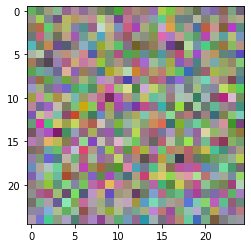

KeyboardInterrupt: ignored

In [7]:

def img2net(img_uint):
  # convert [0, 255] uint8 (H, W, C) to [-1, 1] float32 (1, C, H, W)
  rescaled = (img_uint.astype('float32') / 127.5) - 1.0
  chw = np.transpose(rescaled, (2, 0, 1))
  return torch.from_numpy(np.expand_dims(chw, axis=0)).to(DEVICE)

def net2img(img_float):
  chw = np.squeeze(img_float.detach().cpu().numpy())
  hwc = np.transpose(chw, (1, 2, 0))
  return ((hwc + 1.0) * 127.5).astype('uint8')

generator = SGNet(output_channels=3, kernel_count=32, final_activation=nn.Tanh()).to(DEVICE)
patch_critic = SGNet(output_channels=1, kernel_count=32, final_activation=nn.Identity()).to(DEVICE)
critic = torch.nn.Sequential(patch_critic, Mean()).to(DEVICE)
print(generator)
print(critic)

gen_optimizer = torch.optim.Adam(generator.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
dis_optimizer = torch.optim.Adam(critic.parameters(), LEARNING_RATE, (BETA_1, BETA_2))

gen_sched = torch.optim.lr_scheduler.StepLR(gen_optimizer, LR_DROP_STEP, LR_DROP_MULT)
dis_sched = torch.optim.lr_scheduler.StepLR(dis_optimizer, LR_DROP_STEP, LR_DROP_MULT)

orig_img = img2net(orig_img_uint)
print(orig_img.shape)

def sample_noise(): # check this
  return torch.from_numpy(np.random.uniform(-1, 1, size=orig_img.shape).astype('float32')).to(DEVICE)
  
z_rec = sample_noise()
mse = nn.MSELoss()

for step in range(NUM_ITERS):

  # real 1, fake 0

  for _ in range(GEN_STEP_PER_ITER):
    gen_optimizer.zero_grad()

    z = sample_noise()
    fake_img = generator(z)

    # adversarial loss
    adv_loss = -critic(fake_img)

    # reconstruction loss
    rec_img = generator(z_rec)
    # the representation space of the images is not clear in the paper.
    # since the reconstruction loss seemed very low to us in the [-1, 1]
    # range, we decided to calculate it in the [0, 255] range instead
    # EDIT: after checking out their own code, it seems that there is
    # no multiplier. however, the reconstruction loss remains too small?
    rec_loss = mse(orig_img, rec_img)

    gen_loss = adv_loss + REC_ALPHA * rec_loss
    gen_loss.backward()
    gen_optimizer.step()
    gen_sched.step()

  for _ in range(DIS_STEP_PER_ITER):
    dis_optimizer.zero_grad()

    zc = sample_noise()
    fake_imgc = generator(zc)
    epsilon = np.random.uniform(0, 1)

    # adversarial loss
    # take a sample from the line between the real and generated images
    # for use in the gradient penalty (Impr. Training of WGANs)
    grad_sample = epsilon * orig_img + (1 - epsilon) * fake_imgc
    f_grad_sample = critic(grad_sample)
    grad, = torch.autograd.grad(f_grad_sample, grad_sample, create_graph=True, retain_graph=True)
    grad_loss = (torch.norm(grad) - 1)**2

    fake_loss = critic(fake_imgc)
    real_loss = -critic(orig_img)
    adv_loss =  fake_loss + real_loss + GP_WEIGHT * grad_loss
    adv_loss.backward()
    dis_optimizer.step()
    dis_sched.step()

  if step % PRINT_EVERY == 0:
    print('Step: {}'.format(step))
    print('Generator adv: {:.3f}, rec: {:.3f}'.format(adv_loss.data, rec_loss.data))
    print('Critic fake: {:.3f} real: {:.3f} grad: {:.3f}'.format(fake_loss.data, real_loss.data, grad_loss.data))
    if step != 0:
      elapsed = time() - last_print
      print('Steps per second: {:.2f}'.format(PRINT_EVERY / elapsed))
    plt.imshow(net2img(fake_img))
    plt.show()
    last_print = time()

plt.imshow(net2img(generator(z_rec)))
plt.show()
